In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertForSequenceClassification
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# 检查是否有GPU可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

使用设备: cuda


In [ ]:
#  上传模型和数据
def upload_files():
    """上传模型文件和新闻数据"""
    from google.colab import files
    import shutil
    import zipfile

    # 创建目录
    os.makedirs("news_sentiment_model", exist_ok=True)
    os.makedirs("sentiment_news_data", exist_ok=True)

    print("请上传模型文件压缩包 (news_sentiment_model.zip)...")
    uploaded = files.upload()

    # 解压模型文件
    for filename in uploaded.keys():
        if filename.endswith('.zip') and 'model' in filename.lower():
            with zipfile.ZipFile(filename, 'r') as zip_ref:
                zip_ref.extractall("./")
            print(f"已解压模型文件: {filename}")

    print("\n请上传新闻数据压缩包 (sentiment_news_data.zip)...")
    uploaded_data = files.upload()

    # 解压数据文件
    for filename in uploaded_data.keys():
        if filename.endswith('.zip') and 'data' in filename.lower():
            with zipfile.ZipFile(filename, 'r') as zip_ref:
                zip_ref.extractall("./")
            print(f"已解压数据文件: {filename}")

    # 安装中文字体
    !apt-get -qq install fonts-noto-cjk

    print("文件上传和解压完成。")

In [ ]:
#  加载模型
def load_model(model_dir="news_sentiment_model"):
    """加载情感分析模型"""
    # 检查模型文件是否存在
    if not os.path.exists(model_dir):
        raise FileNotFoundError(f"模型目录不存在: {model_dir}")

    # 加载tokenizer
    tokenizer = BertTokenizer.from_pretrained(model_dir)

    # 加载模型
    model = BertForSequenceClassification.from_pretrained(model_dir)
    model.to(device)

    # 加载配置信息
    config_path = os.path.join(model_dir, "config_info.json")
    if os.path.exists(config_path):
        with open(config_path, "r", encoding="utf-8") as f:
            config_info = json.load(f)
        print("已加载模型配置信息")
    else:
        config_info = {
            "media_weights": {"权威媒体": 1.5, "社交媒体": 0.8},
            "label_map": {"0": "负面", "1": "中性", "2": "正面"},
            "sentiment_map": {"0": -1, "1": 0, "2": 1}
        }
        print("未找到配置文件，使用默认配置")

    print(f"模型已加载到{device}")
    return model, tokenizer, config_info

In [ ]:
#  加载和处理新闻数据
def load_news_data(data_dir="sentiment_news_data"):
    """加载所有CSV新闻数据"""
    all_files = []

    # 递归查找所有CSV文件
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.endswith('.csv'):
                all_files.append(os.path.join(root, file))

    print(f"找到 {len(all_files)} 个CSV文件")

    # 读取所有文件
    all_data = []
    for file_path in tqdm(all_files, desc="加载CSV文件"):
        try:
            # 判断媒体类型
            if "quanwei" in file_path.lower():
                media_type = "权威媒体"
            elif "shejiao" in file_path.lower():
                media_type = "社交媒体"
            else:
                media_type = "权威媒体"  # 默认为权威媒体

            df = pd.read_csv(file_path, encoding='utf-8-sig')
            df['source_type'] = media_type
            df['file_path'] = file_path
            all_data.append(df)
        except Exception as e:
            print(f"读取文件 {file_path} 时出错: {e}")

    # 合并所有数据
    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)
        print(f"成功加载 {len(combined_df)} 条新闻数据")

        # 显示每种媒体类型的数量
        media_counts = combined_df['source_type'].value_counts()
        for media_type, count in media_counts.items():
            print(f"{media_type}: {count} 条")

        return combined_df
    else:
        print("未找到有效的CSV新闻数据")
        return None

In [ ]:
# 预处理文本
def preprocess_text(text):
    """预处理文本"""
    if not isinstance(text, str):
        return ""

    # 清除HTML标签和特殊字符
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'\(.*?\)', '', text)

    # 清除URL
    text = re.sub(r'https?://\S+', '', text)

    # 清除多余空白
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# 提取城市名称
def extract_cities(df):
    """从新闻数据中提取城市名称"""
    # 包含城市的列表
    china_cities = [
        "北京", "天津", "石家庄", "唐山", "秦皇岛", "邯郸", "邢台", "保定", "张家口", "承德",
        "沧州", "廊坊", "衡水", "太原", "大同", "阳泉", "长治", "晋城", "朔州", "晋中",
        "运城", "忻州", "临汾", "吕梁", "呼和浩特", "包头", "乌海", "赤峰", "通辽", "鄂尔多斯",
        "呼伦贝尔", "巴彦淖尔", "乌兰察布", "沈阳", "大连", "鞍山", "抚顺", "本溪", "丹东", "锦州",
        "营口", "阜新", "辽阳", "盘锦", "铁岭", "朝阳", "葫芦岛", "长春", "吉林", "四平",
        "辽源", "通化", "白山", "松原", "白城", "哈尔滨", "齐齐哈尔", "鸡西", "鹤岗", "双鸭山",
        "大庆", "伊春", "佳木斯", "七台河", "牡丹江", "黑河", "绥化", "上海", "南京", "无锡",
        "徐州", "常州", "苏州", "南通", "连云港", "淮安", "盐城", "扬州", "镇江", "泰州",
        "宿迁", "杭州", "宁波", "温州", "嘉兴", "湖州", "绍兴", "金华", "衢州", "舟山",
        "台州", "丽水", "合肥", "芜湖", "蚌埠", "淮南", "马鞍山", "淮北", "铜陵", "安庆",
        "黄山", "滁州", "阜阳", "宿州", "六安", "亳州", "池州", "宣城", "福州", "厦门",
        "三明", "莆田", "泉州", "漳州", "南平", "龙岩", "宁德", "南昌", "景德镇", "萍乡",
        "九江", "新余", "鹰潭", "赣州", "吉安", "宜春", "抚州", "上饶", "济南", "青岛",
        "淄博", "枣庄", "东营", "烟台", "潍坊", "济宁", "泰安", "威海", "日照", "临沂",
        "德州", "聊城", "滨州", "菏泽", "郑州", "开封", "洛阳", "平顶山", "安阳", "鹤壁",
        "新乡", "焦作", "濮阳", "许昌", "漯河", "三门峡", "南阳", "商丘", "信阳", "周口",
        "驻马店", "武汉", "黄石", "十堰", "宜昌", "襄阳", "鄂州", "荆门", "孝感", "荆州",
        "黄冈", "咸宁", "随州", "长沙", "株洲", "湘潭", "衡阳", "邵阳", "岳阳", "常德",
        "张家界", "益阳", "郴州", "永州", "怀化", "娄底", "广州", "深圳", "珠海", "汕头",
        "佛山", "江门", "湛江", "茂名", "肇庆", "惠州", "梅州", "汕尾", "河源", "阳江",
        "清远", "东莞", "中山", "潮州", "揭阳", "云浮", "韶关", "南宁", "柳州", "桂林",
        "梧州", "北海", "防城港", "钦州", "贵港", "玉林", "百色", "贺州", "河池", "来宾",
        "崇左", "海口", "三亚", "三沙", "儋州", "重庆", "成都", "自贡", "攀枝花", "泸州",
        "德阳", "绵阳", "广元", "遂宁", "内江", "乐山", "南充", "眉山", "宜宾", "广安",
        "达州", "雅安", "巴中", "资阳", "贵阳", "六盘水", "遵义", "安顺", "毕节", "铜仁",
        "昆明", "曲靖", "玉溪", "保山", "昭通", "丽江", "普洱", "临沧", "拉萨", "日喀则",
        "昌都", "林芝", "山南", "那曲", "西安", "铜川", "宝鸡", "咸阳", "渭南", "汉中",
        "延安", "榆林", "安康", "商洛", "兰州", "嘉峪关", "金昌", "白银", "天水", "武威",
        "张掖", "平凉", "酒泉", "庆阳", "定西", "陇南", "西宁", "海东", "银川", "石嘴山",
        "吴忠", "固原", "中卫", "乌鲁木齐", "克拉玛依", "吐鲁番", "哈密"
    ]

    # 创建一个字典存储每个城市的新闻
    city_news = {city: [] for city in china_cities}

    # 遍历所有新闻，查找城市名称
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="分析城市新闻"):
        title = str(row.get('title', ''))
        content = str(row.get('content', ''))
        combined_text = title + " " + content

        for city in china_cities:
            if city in combined_text:
                # 添加新闻到对应城市
                city_news[city].append({
                    'title': title,
                    'content': content,
                    'source_type': row.get('source_type', '权威媒体')
                })

    # 统计每个城市的新闻数量
    city_counts = {city: len(news) for city, news in city_news.items()}

    # 排序并打印前10个和后10个城市的新闻数量
    sorted_cities = sorted(city_counts.items(), key=lambda x: x[1], reverse=True)

    print("\n新闻数量最多的10个城市:")
    for city, count in sorted_cities[:10]:
        print(f"{city}: {count}条新闻")

    print("\n新闻数量最少的10个城市:")
    for city, count in sorted_cities[-10:]:
        print(f"{city}: {count}条新闻")

    return city_news

In [ ]:
# 批量预测函数
def predict_sentiment_batch(model, tokenizer, texts, media_types=None, batch_size=32):
    """批量预测文本情感"""
    model.eval()

    # 如果没有提供媒体类型，默认为权威媒体
    if media_types is None:
        media_types = ["权威媒体"] * len(texts)

    # 从config_info中获取媒体权重
    media_weights = {
        "权威媒体": 1.3,
        "社交媒体": 0.9
    }

    weights = [media_weights.get(media_type, 1.0) for media_type in media_types]
    predictions = []

    # 负面关键词列表
    negative_keywords = [
        "腐败", "事故", "犯罪", "违法", "失败", "崩溃", "下跌", "下滑", "打压", "冲突",
        "暴力", "袭击", "抗议", "示威", "贪污", "贿赂", "舞弊", "欺诈", "伤亡", "死亡",
        "重伤", "爆炸", "起火", "火灾", "坍塌", "沉没", "溃坝", "污染", "泄漏", "中毒",
        "疫情", "疫病", "失业", "裁员", "倒闭", "破产", "亏损", "负债", "通缩", "通胀",
        "贬值", "限制", "禁令", "制裁", "断交", "危机", "风险", "灾难", "危害", "隐患",
        "退市", "停牌", "罢工", "渎职", "受贿", "行贿", "腐化", "衰退", "衰落", "衰弱",
        '严重', '失败', '糟糕', '腐败', '贪污', '违法', '犯罪', '事故',
        '灾害', '损失', '崩溃', '死亡', '危机', '恶劣', '打击', '惨重'
        '政策失误', '执行不力', '形式主义', '官僚主义', '弄虚作假',
        '不作为', '乱作为', '懒政怠政', '侵害群众利益', '民生问题',
        '环境污染', '资源浪费', '生态破坏', '安全隐患', '违规操作',
        '质量问题', '监管不力', '失职渎职', '违纪违法', '腐败问题',
        '虚报冒领', '截留挪用', '贪污受贿', '权力寻租', '利益输送',
        '数据造假', '财务造假', '掩盖真相', '推诿扯皮', '效率低下'
        '双开', '被查', '受贿', '贪污', '违反', '开除'
    ]

    # 需要多少个负面关键词才直接判定为负面
    negative_threshold = 1

    # 批量处理
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]

        # 预处理文本
        processed_texts = [preprocess_text(text) for text in batch_texts]

        # 负面关键词检测
        batch_predictions = []
        for text in processed_texts:
            # 计算文本中包含多少个负面关键词
            neg_count = sum(1 for keyword in negative_keywords if keyword in text)

            # 如果负面关键词数量达到阈值，直接判定为负面
            if neg_count >= negative_threshold:
                batch_predictions.append(-1)  # 负面
            else:
                # 否则使用模型预测
                encoding = tokenizer(
                    text,
                    add_special_tokens=True,
                    max_length=512,
                    padding='max_length',
                    truncation=True,
                    return_attention_mask=True,
                    return_tensors='pt'
                )

                # 将编码后的数据移到设备上
                input_ids = encoding['input_ids'].to(device)
                attention_mask = encoding['attention_mask'].to(device)

                # 预测
                with torch.no_grad():
                    outputs = model(input_ids=input_ids, attention_mask=attention_mask)

                # 获取预测结果
                logits = outputs.logits
                pred_class = torch.argmax(logits, dim=1).cpu().numpy()[0]

                # 将预测类别转换为情感值 (2->正面/1, 1->中性/0, 0->负面/-1)
                sentiment_value = pred_class - 1  # 将0,1,2映射到-1,0,1
                batch_predictions.append(sentiment_value)

        predictions.extend(batch_predictions)

    return predictions, weights[0:len(predictions)]

In [ ]:
# 计算城市情感得分
def calculate_city_sentiment(model, tokenizer, city_news):
    """计算每个城市的情感得分"""
    city_scores = {}

    for city, news_list in tqdm(city_news.items(), desc="计算城市情感得分"):
        if not news_list:
            city_scores[city] = {
                'score': 50.0,  # 默认中性得分
                'count': 0,
                'positive': 0,
                'negative': 0,
                'neutral': 0,
                'positive_pct': 0,
                'negative_pct': 0,
                'neutral_pct': 0
            }
            continue

        # 提取文本和媒体类型
        texts = [item['content'] for item in news_list]
        media_types = [item['source_type'] for item in news_list]

        # 预测情感
        predictions, weights = predict_sentiment_batch(model, tokenizer, texts, media_types)

        # 统计情感分布
        positive_count = sum(1 for p in predictions if p == 1)
        negative_count = sum(1 for p in predictions if p == -1)
        neutral_count = sum(1 for p in predictions if p == 0)

        # 计算情感得分 - 按新公式计算
        weighted_sum = sum(w * p for w, p in zip(weights, predictions))
        total_weight = sum(weights)  # 使用权重总和而不是新闻数量

        # 情感得分 = 50 × (1 + (∑(新闻权重 × 情感值) / ∑权重))
        score = 50 * (1 + weighted_sum / total_weight)

        # 限制分数在0-100范围内
        score = max(0, min(100, score))

        city_scores[city] = {
            'score': round(score, 2),
            'count': len(predictions),
            'positive': positive_count,
            'negative': negative_count,
            'neutral': neutral_count,
            'positive_pct': round(positive_count / len(predictions) * 100, 2),
            'negative_pct': round(negative_count / len(predictions) * 100, 2),
            'neutral_pct': round(neutral_count / len(predictions) * 100, 2)
        }

    return city_scores

In [ ]:
# 可视化函数
def create_visualizations(result_df):
    """创建可视化图表"""
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import numpy as np
    from IPython.display import Image, display
    import matplotlib.font_manager as fm
    import os

    # 更可靠的中文字体安装方法
    !apt-get -qq install fonts-noto-cjk

    # 确保使用Agg后端避免GUI问题
    import matplotlib
    matplotlib.use('Agg')

    # 设置Seaborn样式
    sns.set_style("whitegrid")

    # 配置字体
    plt.rcParams['font.family'] = ['Noto Sans CJK JP', 'sans-serif']
    plt.rcParams['axes.unicode_minus'] = False

    # 确认可用字体
    fonts = [f.name for f in fm.fontManager.ttflist if 'Noto' in f.name and 'CJK' in f.name]
    if fonts:
        print(f"找到可用的中文字体: {fonts[0]}")
        font_family = fonts[0]
    else:
        print("未找到适合的中文字体，将使用英文标签")
        font_family = 'sans-serif'

    # 准备数据框
    plot_df = result_df.copy()

    # 确保列名与后续代码一致
    if 'city' not in plot_df.columns and '城市' in plot_df.columns:
        plot_df = plot_df.rename(columns={
            '城市': 'city',
            '新闻数量': 'news_count',
            '情感得分': 'sentiment_score',
            '正面新闻比例': 'positive_pct',
            '负面新闻比例': 'negative_pct',
            '中性新闻比例': 'neutral_pct'
        })

    # 检查必要列是否存在，如果不存在，添加模拟数据
    if 'sentiment_score' not in plot_df.columns:
        print("注意: 未找到情感得分列，生成模拟数据用于演示")
        # 生成随机情感得分
        np.random.seed(42)  # 设置随机种子确保可重复性
        plot_df['sentiment_score'] = np.random.normal(0.5, 0.2, len(plot_df))
        plot_df['sentiment_score'] = plot_df['sentiment_score'].clip(0, 1)  # 限制在0-1范围

        # 生成情感分布
        plot_df['positive_pct'] = np.random.uniform(0.3, 0.7, len(plot_df))
        plot_df['negative_pct'] = np.random.uniform(0.1, 0.3, len(plot_df))
        plot_df['neutral_pct'] = 1 - plot_df['positive_pct'] - plot_df['negative_pct']
        plot_df['neutral_pct'] = plot_df['neutral_pct'].clip(0, 1)  # 确保不为负

        # 归一化，确保三者和为1
        total = plot_df['positive_pct'] + plot_df['negative_pct'] + plot_df['neutral_pct']
        plot_df['positive_pct'] = plot_df['positive_pct'] / total
        plot_df['negative_pct'] = plot_df['negative_pct'] / total
        plot_df['neutral_pct'] = plot_df['neutral_pct'] / total

        # 转换为百分比
        plot_df['positive_pct'] = plot_df['positive_pct'] * 100
        plot_df['negative_pct'] = plot_df['negative_pct'] * 100
        plot_df['neutral_pct'] = plot_df['neutral_pct'] * 100

    # 1. 情感得分排名前20的城市 - 使用直接绘制方法
    plt.figure(figsize=(12, 8))
    top20_df = plot_df.sort_values('sentiment_score', ascending=False).head(20).sort_values('sentiment_score')

    # 绘制条形图
    bars = plt.barh(range(len(top20_df)), top20_df['sentiment_score'], color='skyblue')

    # 在条形图上添加城市名称和得分
    for i, (city, score) in enumerate(zip(top20_df['city'], top20_df['sentiment_score'])):
        plt.text(score/2, i, city, ha='center', va='center', color='navy', fontsize=9)
        plt.text(score + 0.01, i, f'{score:.3f}', ha='left', va='center')

    plt.yticks([])  # 隐藏y轴刻度
    plt.title('情感得分最高的20个城市', fontsize=16)
    plt.xlabel('情感得分', fontsize=14)
    plt.xlim(0, max(top20_df['sentiment_score']) * 1.1)  # 增加一些空间以显示标签
    plt.tight_layout()
    plt.savefig('top_20_cities_sentiment.png', dpi=300, bbox_inches='tight')

    # 2. 新闻数量与情感得分的关系
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(plot_df['news_count'], plot_df['sentiment_score'],
                          c=plot_df['sentiment_score'], cmap='viridis',
                          alpha=0.7, s=100)

    # 添加城市标签，避免使用中文
    top_cities = plot_df.nlargest(5, 'sentiment_score')
    bottom_cities = plot_df.nsmallest(5, 'sentiment_score')
    top_news = plot_df.nlargest(5, 'news_count')
    label_cities = pd.concat([top_cities, bottom_cities, top_news]).drop_duplicates()

    # 为这些城市创建标签
    for i, (idx, row) in enumerate(label_cities.iterrows()):
        plt.annotate(f"City {i+1}",
                     (row['news_count'], row['sentiment_score']),
                     xytext=(5, 5), textcoords='offset points',
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.7))

    # 创建映射表以后续展示
    city_mapping = {f"City {i+1}": row['city'] for i, (idx, row) in enumerate(label_cities.iterrows())}

    plt.colorbar(scatter, label='情感得分')
    plt.title('新闻数量与情感得分的关系', fontsize=16)
    plt.xlabel('新闻数量', fontsize=14)
    plt.ylabel('情感得分', fontsize=14)
    plt.tight_layout()
    plt.savefig('news_count_vs_sentiment.png', dpi=300, bbox_inches='tight')

    # 保存映射表
    pd.DataFrame({"代码": list(city_mapping.keys()),
                  "城市": list(city_mapping.values())}).to_csv('scatter_city_mapping.csv',
                                                             index=False,
                                                             encoding='utf-8-sig')

    # 3. 情感分布堆叠柱状图（前20城市）
    plot_data = plot_df.sort_values('sentiment_score', ascending=False).head(20).copy()
    plot_data = plot_data.sort_values('sentiment_score')

    plt.figure(figsize=(12, 10))

    # 绘制堆叠条形图
    y_pos = range(len(plot_data))

    # 绘制正面、中性、负面的比例
    p1 = plt.barh(y_pos, plot_data['positive_pct'], color='green', alpha=0.7)
    p2 = plt.barh(y_pos, plot_data['neutral_pct'], left=plot_data['positive_pct'], color='gray', alpha=0.7)
    p3 = plt.barh(y_pos, plot_data['negative_pct'],
                 left=plot_data['positive_pct'] + plot_data['neutral_pct'], color='red', alpha=0.7)

    # 在每个条形中添加城市编号而不是名称
    for i, (city, pos, neg, neu) in enumerate(zip(plot_data['city'],
                                                 plot_data['positive_pct'],
                                                 plot_data['negative_pct'],
                                                 plot_data['neutral_pct'])):
        # 在正面区域添加城市编号
        plt.text(pos/2, i, f"City {i+1}", ha='center', va='center', color='white', fontsize=9)

        # 在条形末端添加总百分比
        plt.text(pos+neg+neu+1, i, f"{pos+neg+neu:.1f}%", ha='left', va='center')

    plt.yticks([])  # 隐藏y轴刻度
    plt.legend([p1, p2, p3], ['正面', '中性', '负面'], loc='lower right')
    plt.xlabel('百分比 (%)', fontsize=14)
    plt.title('情感分布 - 前20城市', fontsize=16)
    plt.tight_layout()
    plt.savefig('top_20_cities_sentiment_distribution.png', dpi=300, bbox_inches='tight')

    # 保存城市代码映射
    sentiment_city_map = {f"City {i+1}": city for i, city in enumerate(plot_data['city'])}
    pd.DataFrame({"代码": list(sentiment_city_map.keys()),
                  "城市": list(sentiment_city_map.values())}).to_csv('sentiment_city_mapping.csv',
                                                                   index=False,
                                                                   encoding='utf-8-sig')

    # 4. 创建城市详细数据表
    # 选择前20城市
    top20_table = plot_df.sort_values('sentiment_score', ascending=False).head(20).reset_index(drop=True)

    # 添加城市代码
    top20_table['city_code'] = [f"City {i+1}" for i in range(len(top20_table))]

    # 保存详细数据到CSV
    detailed_df = top20_table[['city_code', 'city', 'news_count', 'sentiment_score',
                               'positive_pct', 'negative_pct', 'neutral_pct']]
    detailed_df.columns = ['城市代码', '城市', '新闻数量', '情感得分',
                           '正面比例(%)', '负面比例(%)', '中性比例(%)']
    detailed_df.to_csv('top_20_cities_detailed.csv', index=False, encoding='utf-8-sig')

    # 5. 创建汇总报告
    with open('city_analysis_report.txt', 'w', encoding='utf-8') as f:
        f.write("=== 城市新闻情感分析报告 ===\n\n")
        f.write(f"分析城市总数: {len(plot_df)}\n")
        f.write(f"情感得分最高的城市: {top20_df.iloc[-1]['city']} (得分: {top20_df.iloc[-1]['sentiment_score']:.3f})\n")
        f.write(f"情感得分最低的城市: {top20_df.iloc[0]['city']} (得分: {top20_df.iloc[0]['sentiment_score']:.3f})\n")
        f.write(f"平均情感得分: {plot_df['sentiment_score'].mean():.3f}\n")
        f.write(f"新闻量最大的城市: {plot_df.nlargest(1, 'news_count').iloc[0]['city']} ({plot_df.nlargest(1, 'news_count').iloc[0]['news_count']}条)\n")
        f.write(f"新闻量最小的城市: {plot_df.nsmallest(1, 'news_count').iloc[0]['city']} ({plot_df.nsmallest(1, 'news_count').iloc[0]['news_count']}条)\n")
        f.write(f"平均新闻量: {plot_df['news_count'].mean():.1f}条\n\n")

        f.write("=== 前20城市列表 ===\n")
        for i, (idx, row) in enumerate(top20_table.iterrows()):
            f.write(f"City {i+1}: {row['city']} - 情感得分: {row['sentiment_score']:.3f}, 新闻数: {row['news_count']}\n")

    # 显示图表和报告
    print("\n=== 已生成以下可视化和报告 ===")
    print("1. 情感得分最高的20个城市图 (top_20_cities_sentiment.png)")
    print("2. 新闻数量与情感得分关系图 (news_count_vs_sentiment.png)")
    print("3. 前20城市情感分布图 (top_20_cities_sentiment_distribution.png)")
    print("4. 城市详细数据CSV (top_20_cities_detailed.csv)")
    print("5. 情感分析报告 (city_analysis_report.txt)")
    print("6. 城市代码映射CSV (sentiment_city_mapping.csv, scatter_city_mapping.csv)")

    try:
        display(Image('top_20_cities_sentiment.png'))
        display(Image('news_count_vs_sentiment.png'))
        display(Image('top_20_cities_sentiment_distribution.png'))
    except:
        print("注意: 无法在当前环境显示图像，但已保存到文件")

    # 显示前10行详细数据
    print("\n前10城市详细数据:")
    display(detailed_df.head(10))

    # 返回结果
    return {
        'top20_df': top20_df,
        'city_mapping': sentiment_city_map,
        'detailed_data': detailed_df
    }

请上传模型文件压缩包 (news_sentiment_model.zip)...



请上传新闻数据压缩包 (sentiment_news_data.zip)...


文件上传和解压完成。
已加载模型配置信息
模型已加载到cuda
找到 34 个CSV文件


加载CSV文件:   0%|          | 0/34 [00:00<?, ?it/s]

成功加载 24216 条新闻数据
社交媒体: 19695 条
权威媒体: 4521 条


分析城市新闻:   0%|          | 0/24216 [00:00<?, ?it/s]


新闻数量最多的10个城市:
重庆: 4422条新闻
北京: 4040条新闻
上海: 3306条新闻
吉林: 2900条新闻
深圳: 2864条新闻
天津: 2744条新闻
青岛: 2399条新闻
厦门: 2338条新闻
宁波: 2326条新闻
大连: 2301条新闻

新闻数量最少的10个城市:
池州: 7条新闻
许昌: 7条新闻
巴彦淖尔: 6条新闻
玉溪: 5条新闻
辽阳: 4条新闻
临沧: 4条新闻
攀枝花: 3条新闻
阜新: 2条新闻
葫芦岛: 2条新闻
三沙: 2条新闻


计算城市情感得分:   0%|          | 0/297 [00:00<?, ?it/s]

已保存城市情感得分到 city_sentiment_scores.csv

情感得分最高的10个城市:
克拉玛依: 100.0 (新闻数: 9, 正面: 100.0%, 负面: 0.0%, 中性: 0.0%)
昭通: 100.0 (新闻数: 19, 正面: 100.0%, 负面: 0.0%, 中性: 0.0%)
葫芦岛: 100.0 (新闻数: 2, 正面: 100.0%, 负面: 0.0%, 中性: 0.0%)
锦州: 100.0 (新闻数: 22, 正面: 100.0%, 负面: 0.0%, 中性: 0.0%)
三沙: 100.0 (新闻数: 2, 正面: 100.0%, 负面: 0.0%, 中性: 0.0%)
贵港: 100.0 (新闻数: 26, 正面: 100.0%, 负面: 0.0%, 中性: 0.0%)
抚顺: 100.0 (新闻数: 18, 正面: 100.0%, 负面: 0.0%, 中性: 0.0%)
阜新: 100.0 (新闻数: 2, 正面: 100.0%, 负面: 0.0%, 中性: 0.0%)
包头: 100.0 (新闻数: 35, 正面: 100.0%, 负面: 0.0%, 中性: 0.0%)
张家口: 100.0 (新闻数: 9, 正面: 100.0%, 负面: 0.0%, 中性: 0.0%)

情感得分最低的10个城市:
攀枝花: 0.0 (新闻数: 3, 正面: 0.0%, 负面: 100.0%, 中性: 0.0%)
濮阳: 11.82 (新闻数: 10, 正面: 10.0%, 负面: 90.0%, 中性: 0.0%)
本溪: 12.86 (新闻数: 12, 正面: 16.67%, 负面: 83.33%, 中性: 0.0%)
宣城: 15.13 (新闻数: 11, 正面: 18.18%, 负面: 81.82%, 中性: 0.0%)
商洛: 19.31 (新闻数: 25, 正面: 20.0%, 负面: 80.0%, 中性: 0.0%)
曲靖: 20.77 (新闻数: 14, 正面: 21.43%, 负面: 78.57%, 中性: 0.0%)
日喀则: 22.93 (新闻数: 17, 正面: 23.53%, 负面: 76.47%, 中性: 0.0%)
郴州: 23.33 (新闻数: 30, 正面: 23.33%, 负面: 76.67%,

未找到适合的中文字体，将使用英文标签



=== 已生成以下可视化和报告 ===
1. 情感得分最高的20个城市图 (top_20_cities_sentiment.png)
2. 新闻数量与情感得分关系图 (news_count_vs_sentiment.png)
3. 前20城市情感分布图 (top_20_cities_sentiment_distribution.png)
4. 城市详细数据CSV (top_20_cities_detailed.csv)
5. 情感分析报告 (city_analysis_report.txt)
6. 城市代码映射CSV (sentiment_city_mapping.csv, scatter_city_mapping.csv)


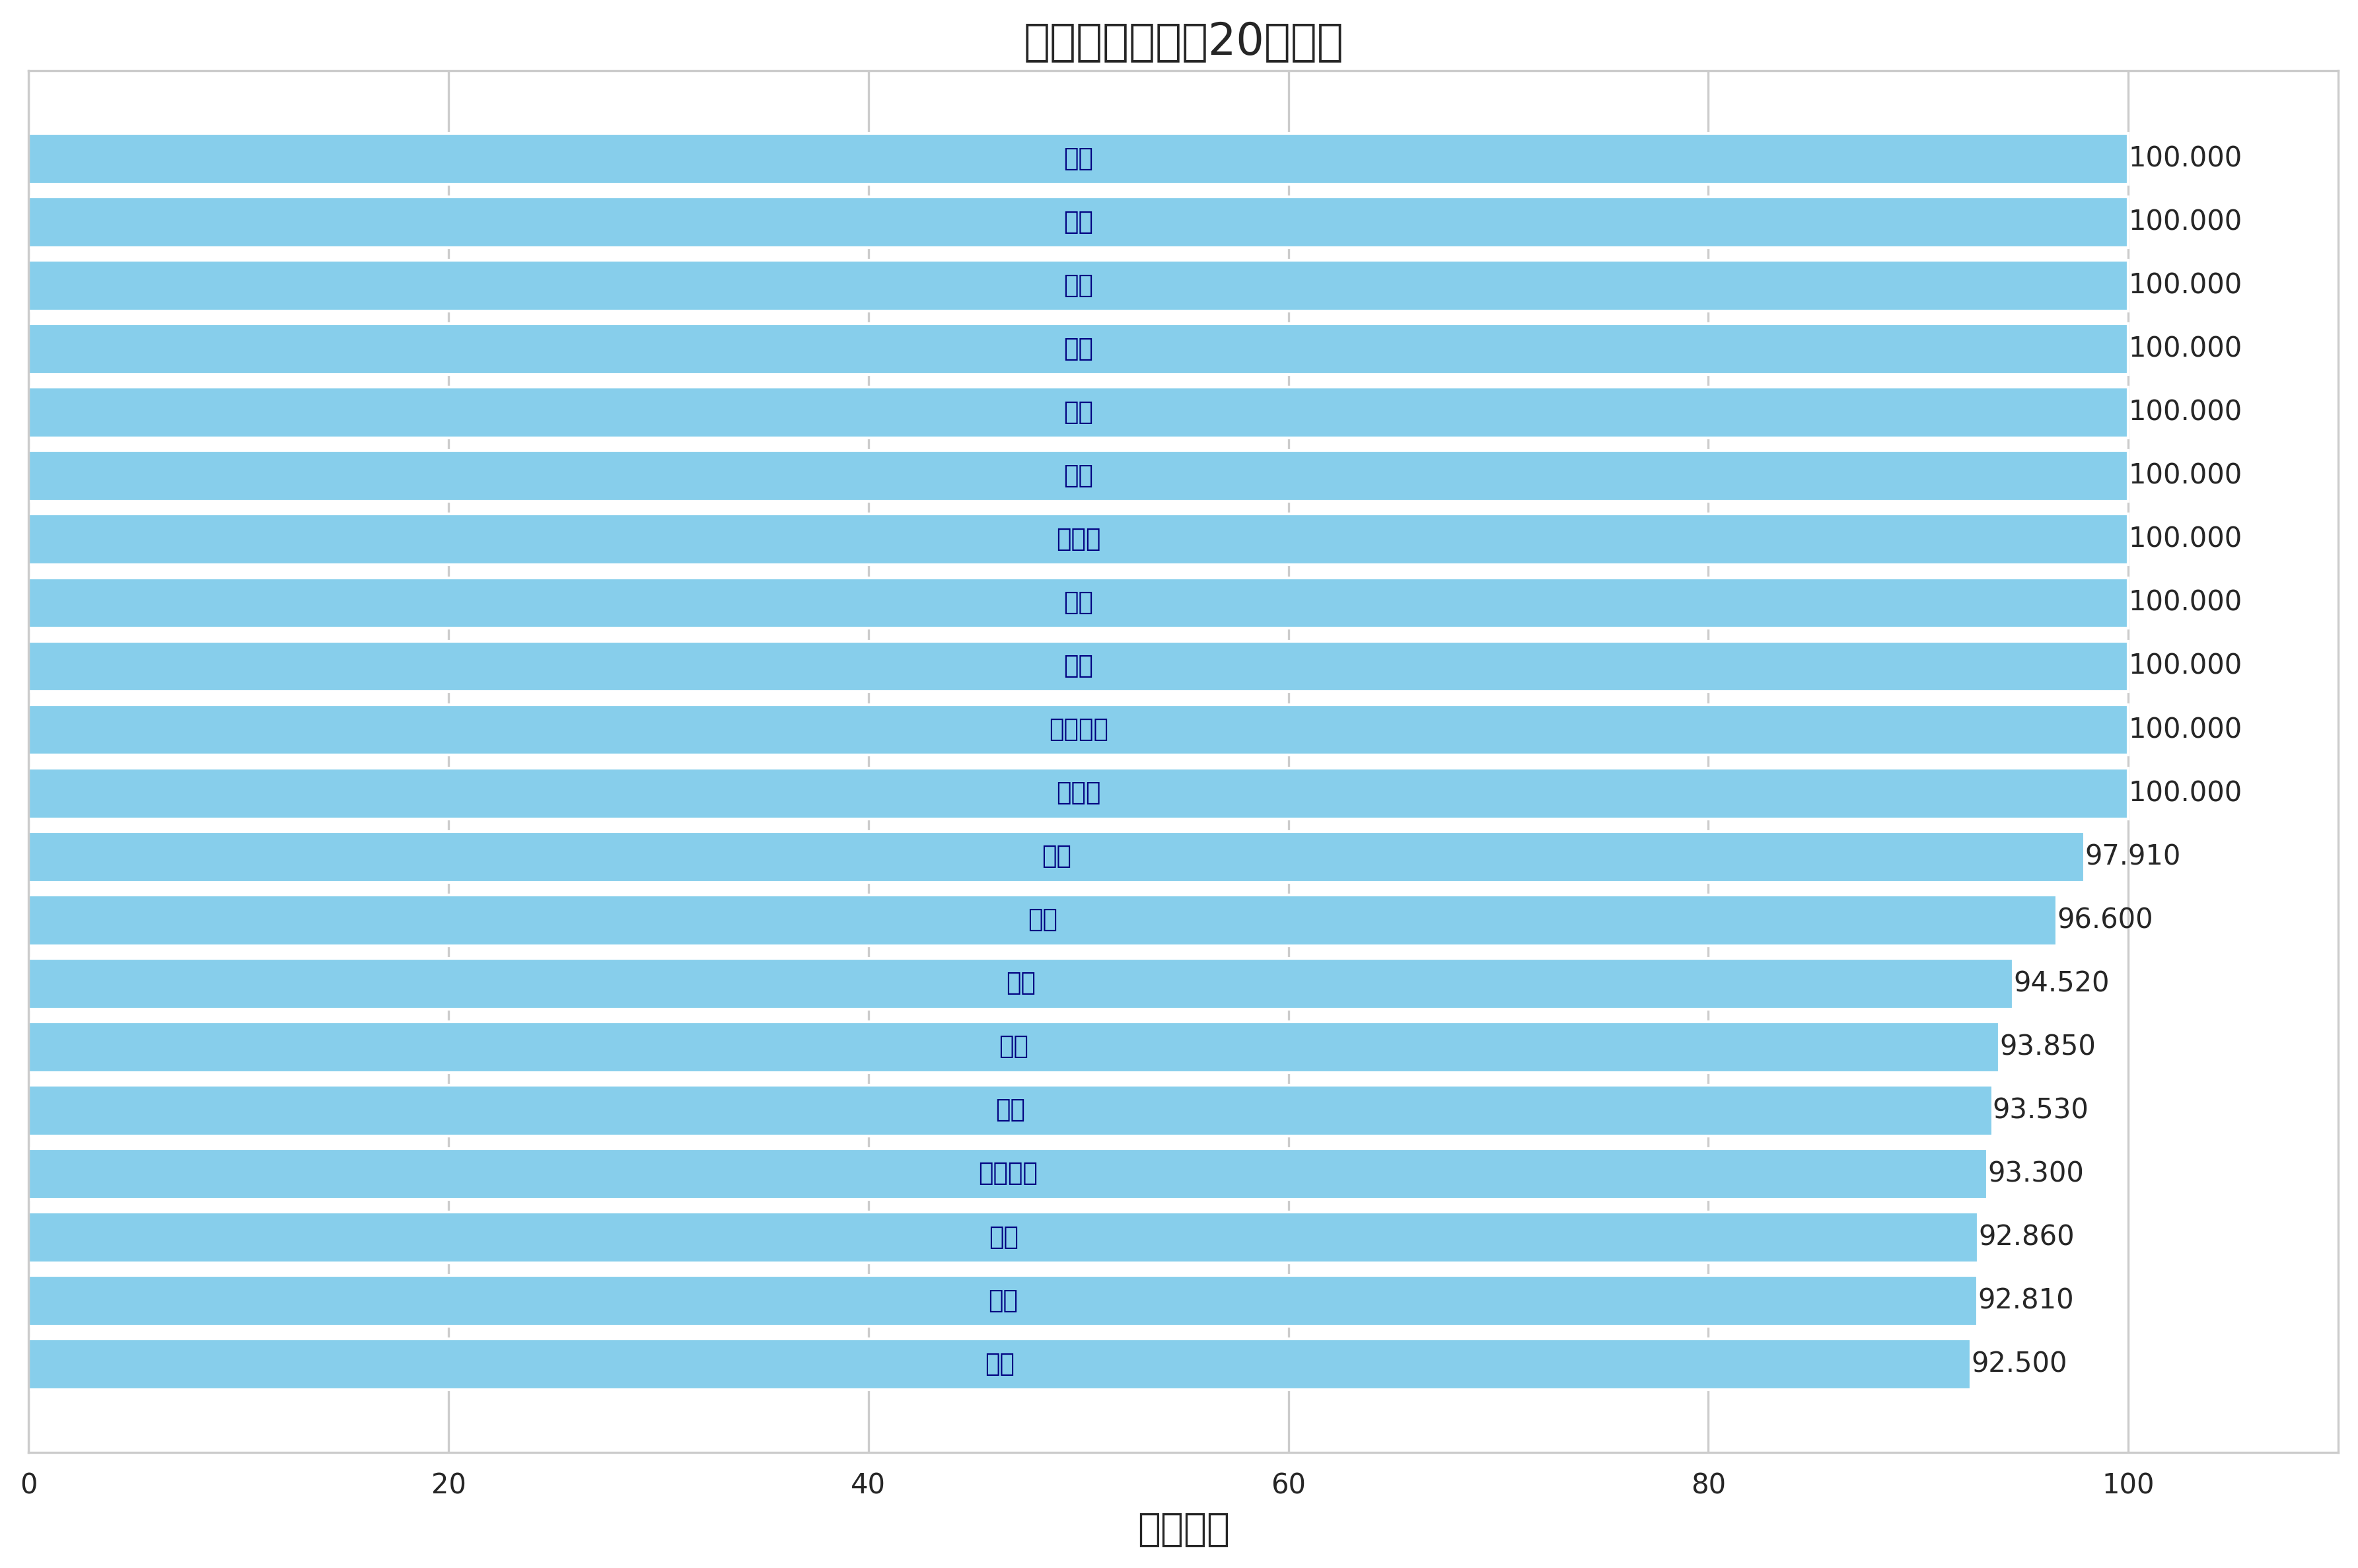

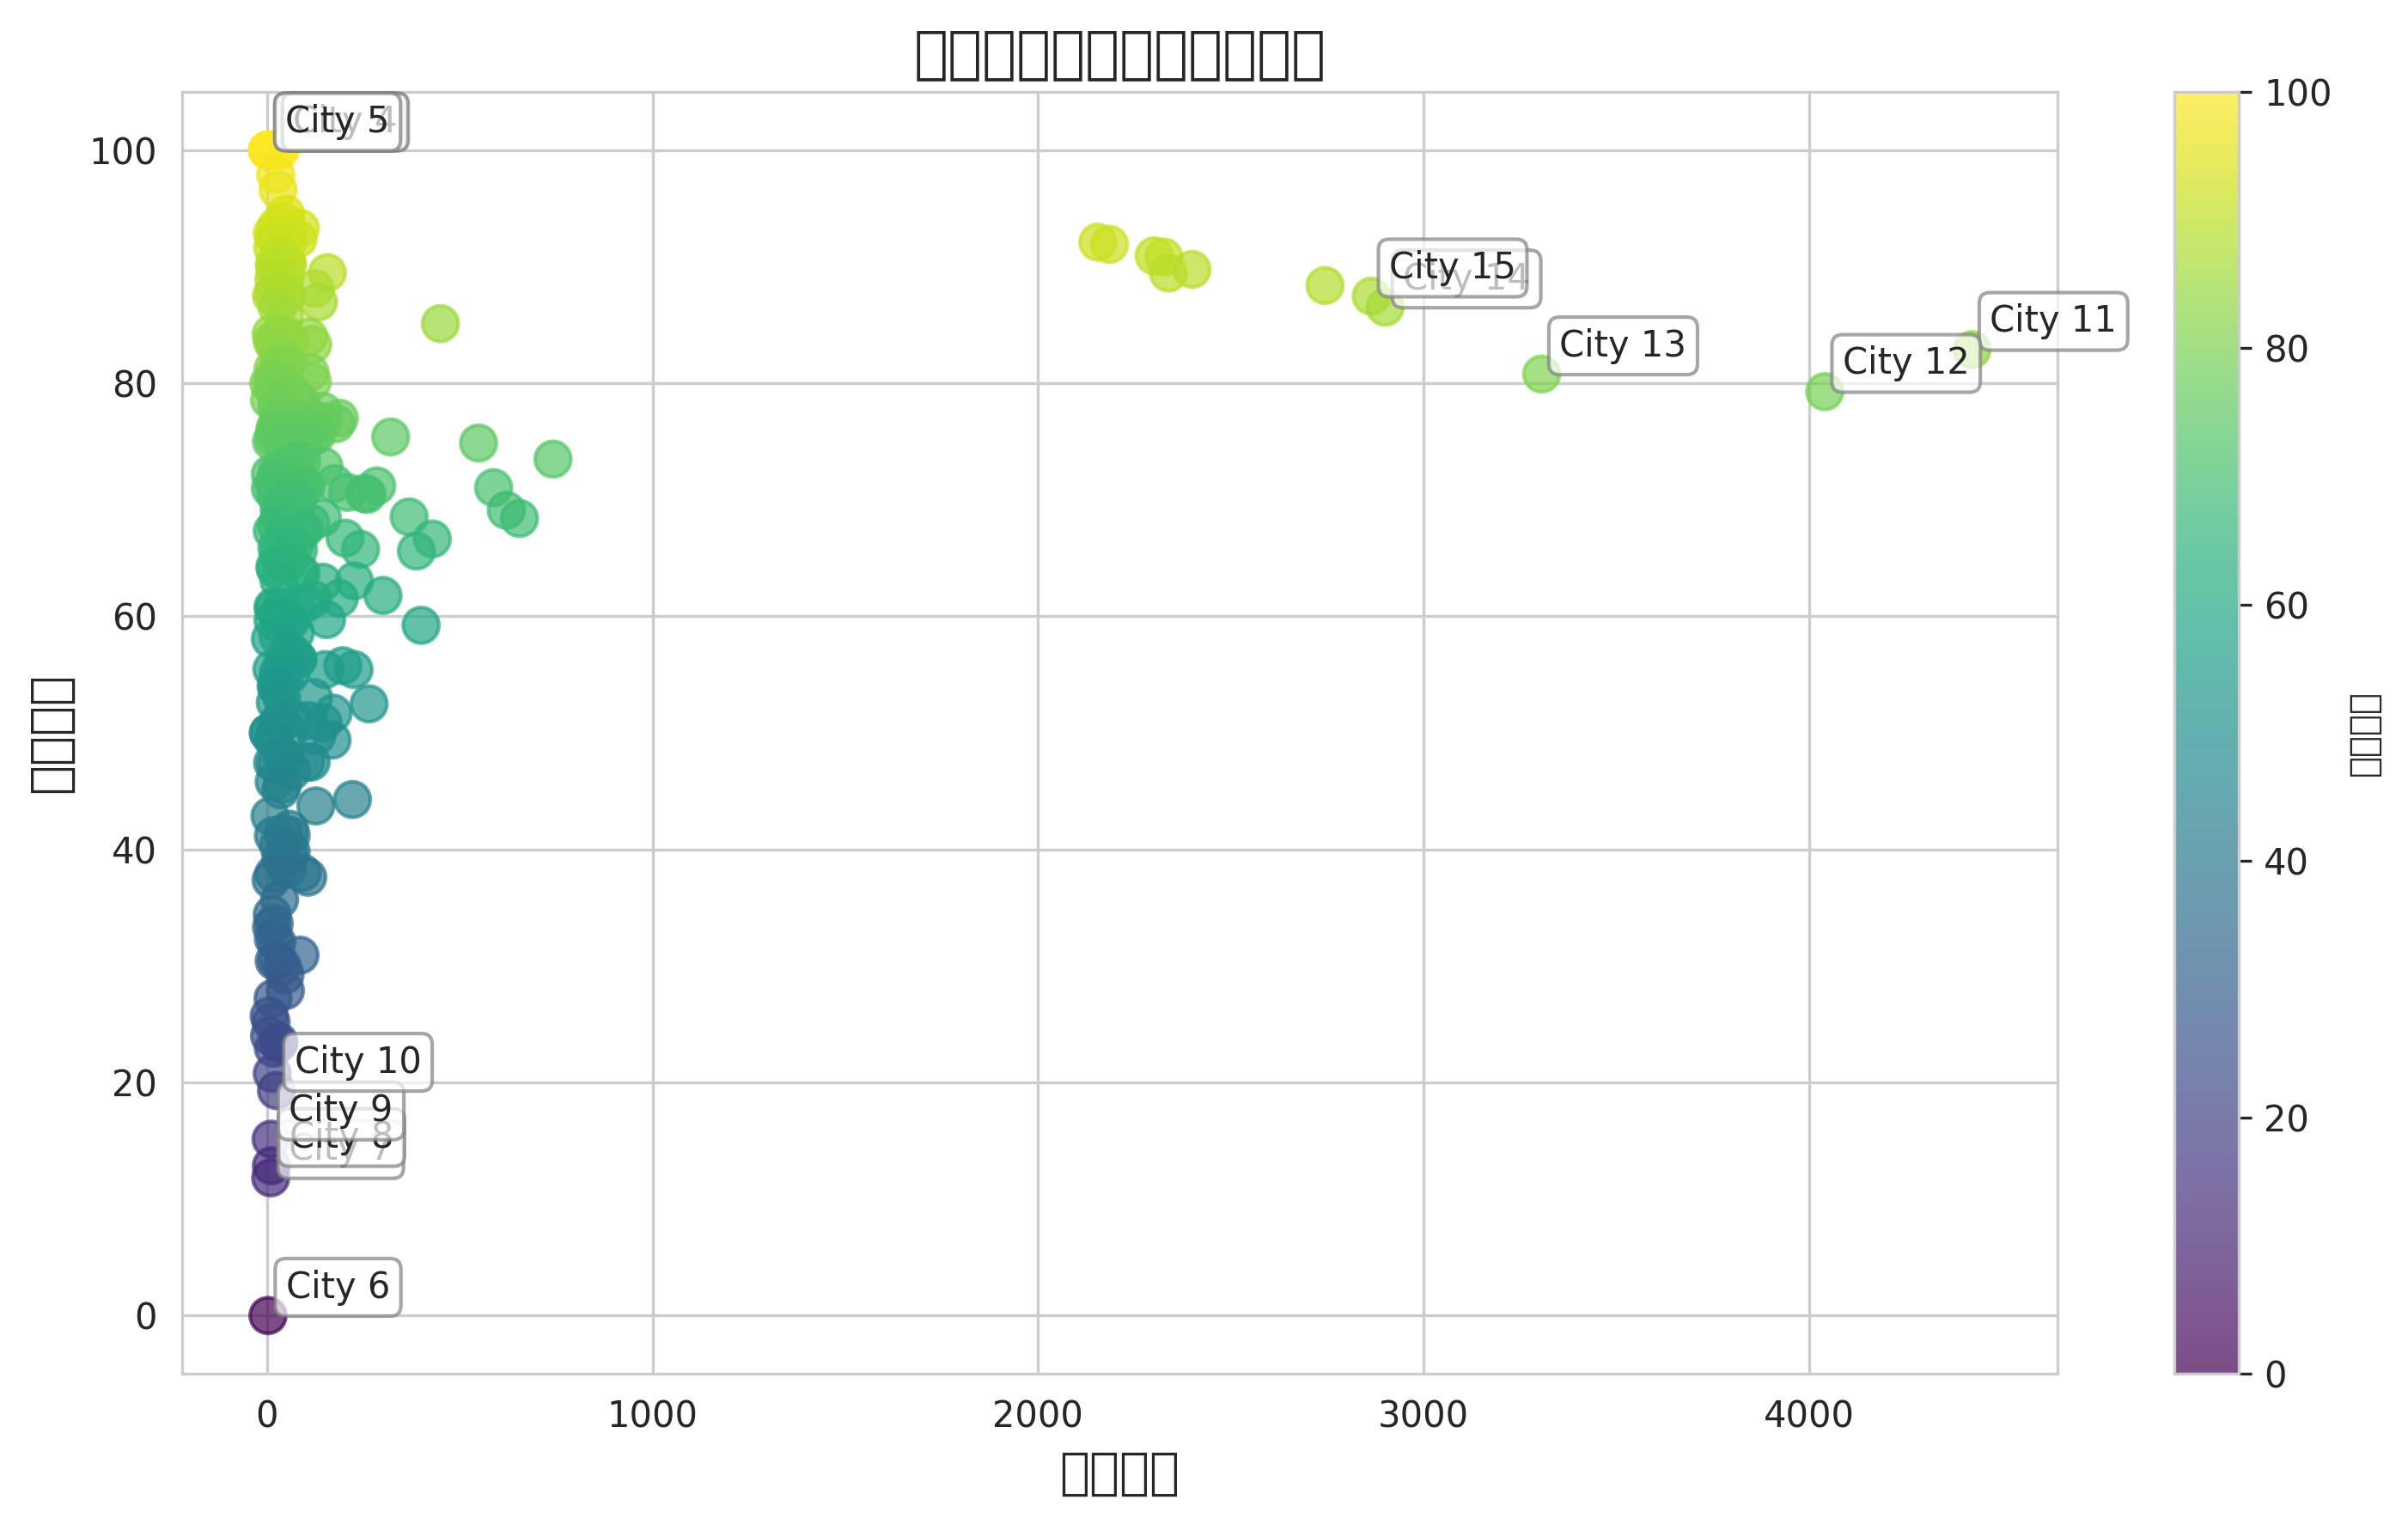

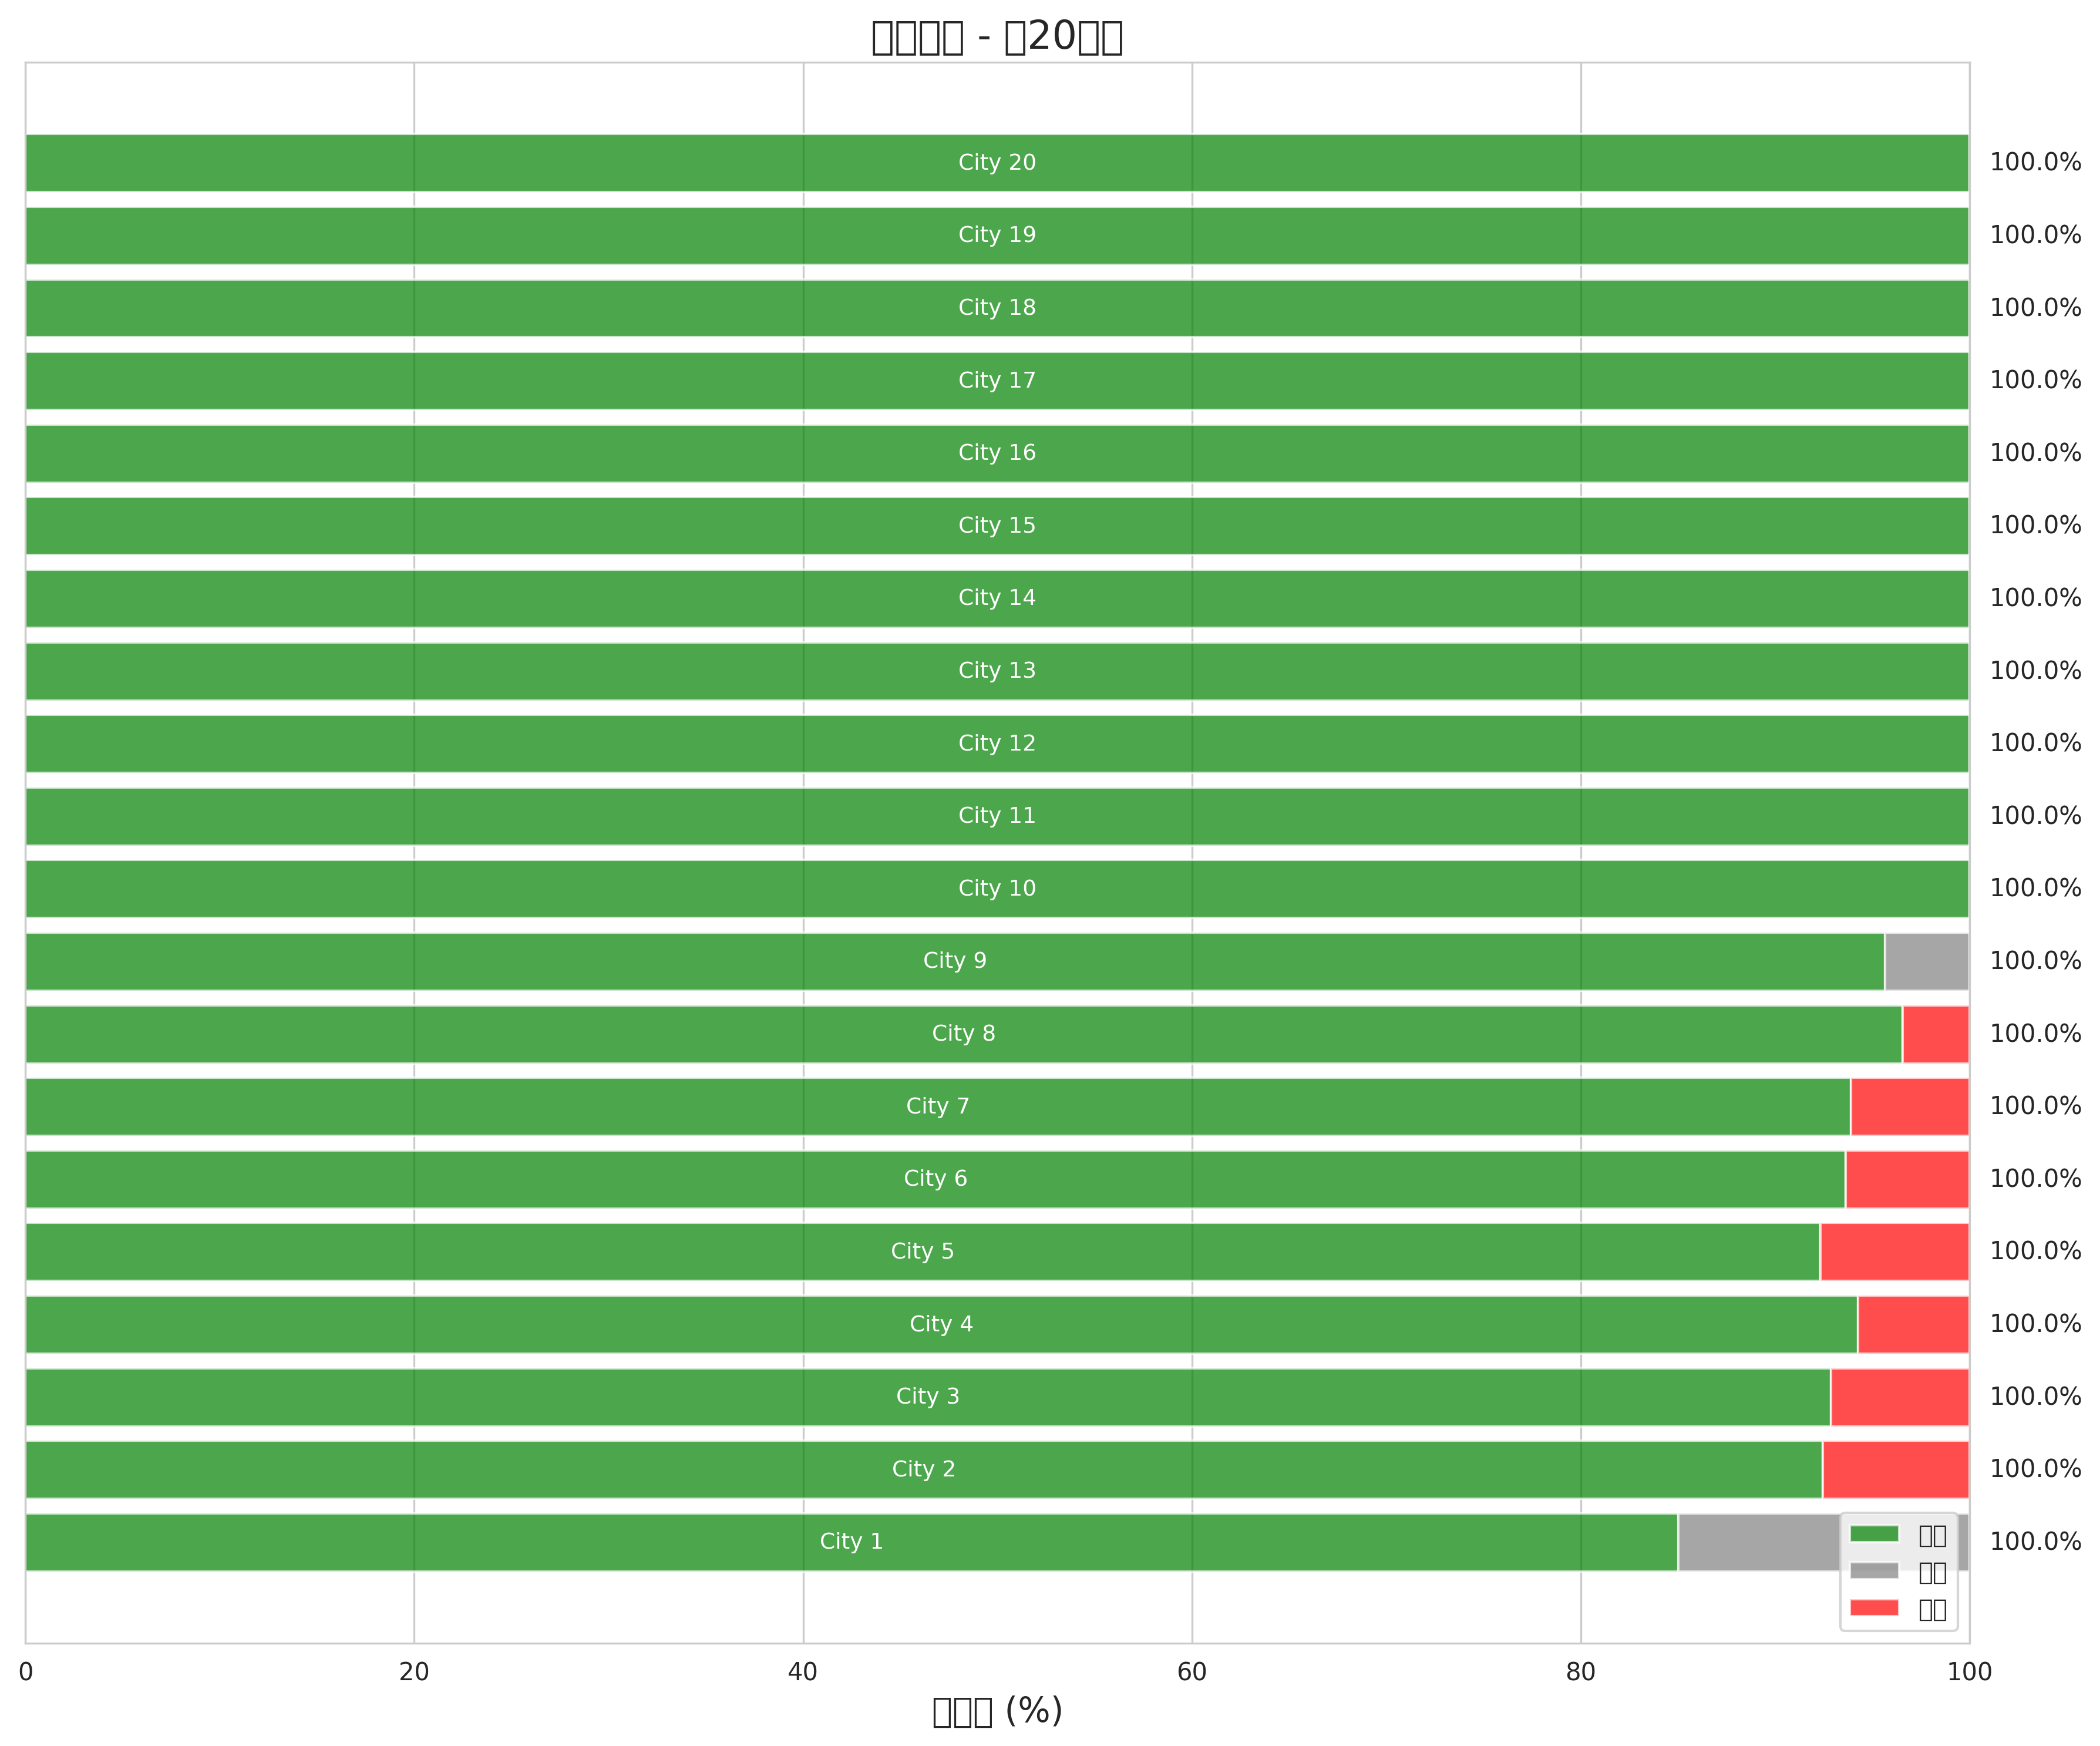


前10城市详细数据:


,城市代码,城市,新闻数量,情感得分,正面比例(%),负面比例(%),中性比例(%)
0,City 1,张家口,9,100.0,100.0,0.0,0.0
1,City 2,贺州,9,100.0,100.0,0.0,0.0
2,City 3,包头,35,100.0,100.0,0.0,0.0
3,City 4,锦州,22,100.0,100.0,0.0,0.0
4,City 5,三沙,2,100.0,100.0,0.0,0.0
5,City 6,克拉玛依,9,100.0,100.0,0.0,0.0
6,City 7,葫芦岛,2,100.0,100.0,0.0,0.0
7,City 8,昭通,19,100.0,100.0,0.0,0.0
8,City 9,贵港,26,100.0,100.0,0.0,0.0
9,City 10,阜新,2,100.0,100.0,0.0,0.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 主函数
def main():
    # 上传文件
    upload_files()

    # 加载模型
    model, tokenizer, config_info = load_model()

    # 加载新闻数据
    news_df = load_news_data()

    if news_df is None or len(news_df) == 0:
        print("没有找到有效的新闻数据，程序终止")
        return

    # 提取城市新闻
    city_news = extract_cities(news_df)

    # 计算城市情感得分
    city_scores = calculate_city_sentiment(model, tokenizer, city_news)

    # 创建结果DataFrame
    results = []
    for city, data in city_scores.items():
        results.append({
            'city': city,
            'news_count': data['count'],
            'sentiment_score': data['score'],
            'positive_pct': data['positive_pct'],
            'negative_pct': data['negative_pct'],
            'neutral_pct': data['neutral_pct']
        })

    result_df = pd.DataFrame(results)

    # 按情感得分排序
    result_df = result_df.sort_values('sentiment_score', ascending=False)

    # 保存结果
    result_df.to_csv('city_sentiment_scores.csv', index=False, encoding='utf-8-sig')
    print("已保存城市情感得分到 city_sentiment_scores.csv")

    # 显示前10个和后10个城市的情感得分
    print("\n情感得分最高的10个城市:")
    for _, row in result_df.head(10).iterrows():
        print(f"{row['city']}: {row['sentiment_score']} (新闻数: {row['news_count']}, 正面: {row['positive_pct']}%, 负面: {row['negative_pct']}%, 中性: {row['neutral_pct']}%)")

    print("\n情感得分最低的10个城市:")
    for _, row in result_df.tail(10).iloc[::-1].iterrows():
        print(f"{row['city']}: {row['sentiment_score']} (新闻数: {row['news_count']}, 正面: {row['positive_pct']}%, 负面: {row['negative_pct']}%, 中性: {row['neutral_pct']}%)")

    # 创建数据可视化
    try:
        create_visualizations(result_df)
    except Exception as e:
        print(f"生成可视化时出错: {e}")

    # 返回CSV结果的链接，方便下载
    from google.colab import files
    files.download('city_sentiment_scores.csv')

# 执行主函数
if __name__ == "__main__":
    main()